<a href="https://colab.research.google.com/github/farhanwadia/mie443_contest3/blob/Henry/MIE443_Final_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall --y torch

Uninstalling torch-1.8.1+cu101:
ERROR: Operation cancelled by user


In [ ]:
!pip install torch==1.4.0

In [ ]:
import torch
print(torch.__version__)

1.8.1+cu101


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q '/content/drive/My Drive/UofT/Fourth Year/MIE443/train_split.zip'

In [3]:
import torch
import torch.nn as nn
import argparse
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, models
from sklearn.model_selection import KFold

#Support Functions

###Input Args

In [4]:
def getInputArgs():
    parser = argparse.ArgumentParser('Sample for training an emotion classification model.')
    parser.add_argument('--gpu', dest='gpu', default=torch.cuda.is_available(), type=bool, help='Use gpu for training')
    parser.add_argument('--nepoch', dest='nepoch', default=10, type=int, help='Number of training epochs')
    parser.add_argument('--mdl', dest='mdl', default=None, type=str, help='Model to load')
    parser.add_argument('--val', dest='val', action='store_true', help='Get validation score')
    parser.add_argument('-f')
    args = parser.parse_args()
    return args

###Data Loader

In [5]:
def getDataloader(all_imgs, all_labels, train_ids, test_ids, batch_size = 128):
    
    train_imgs = all_imgs[train_ids]
    train_labels = all_labels[train_ids]
    val_imgs = all_imgs[test_ids]
    val_labels = all_labels[test_ids]

    train_dataset = torch.utils.data.TensorDataset(*(train_imgs, train_labels))
    val_dataset = torch.utils.data.TensorDataset(*(val_imgs, val_labels))

    # Due to class imbalance introduce a weighted random sampler to select rare classes more often.
    weights_label = train_labels.unique(return_counts=True, sorted=True)[1].float().reciprocal()
    weights = torch.zeros_like(train_labels, dtype=torch.float)
    for idx, label in enumerate(train_labels):
        weights[idx] = weights_label[label]
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

    # Create the dataloaders for the different datasets.
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            num_workers=2, sampler=sampler,)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    return train_loader, val_loader

###Get acc

In [6]:
def calc_acc(mdl, dl, dl_type, device):
    print('')
    with torch.no_grad():
        pbar = tqdm(dynamic_ncols=True, total=int(len(dl)))
        total = 0
        ncorrect = 0
        for nex, ex in enumerate(dl):
            ims, labels, = ex
            ims = ims.to(device)
            labels = labels.to(device)
            predicted = mdl(ims, True)
            total += labels.size(0)
            ncorrect += (predicted == labels).sum().item()
            status = '%s ACC: %.4f '%(dl_type, float(ncorrect) / total)
            pbar.set_description(status)
            pbar.update(1)
    pbar.close()
    return float(ncorrect) / total

###Get acc - no bar

In [7]:
def calc_acc(mdl, dl, dl_type, device):
    #print('')
    with torch.no_grad():
        #pbar = tqdm(dynamic_ncols=True, total=int(len(dl)))
        total = 0
        ncorrect = 0
        for nex, ex in enumerate(dl):
            ims, labels, = ex
            ims = ims.to(device)
            labels = labels.to(device)
            predicted = mdl(ims, True)
            total += labels.size(0)
            ncorrect += (predicted == labels).sum().item()
            status = '%s ACC: %.4f '%(dl_type, float(ncorrect) / total)
            #pbar.set_description(status)
            #pbar.update(1)
    #pbar.close()
    return float(ncorrect) / total

###Reset Weights

In [8]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

###Regular Training

In [9]:
def train_loop(mdl, loss_fn, optim, dl, device):
    #print('')
    #pbar = tqdm(dynamic_ncols=True, total=int(len(dl)))
    n_batch_loss = 50
    running_loss = 0
    for nex, ex in enumerate(dl):
        ims, labels, = ex
        ims = ims.to(device)
        labels = labels.to(device)
        #
        # Optimization.
        optim.zero_grad()
        outs = mdl(ims)
        loss = loss_fn(outs, labels)
        loss.backward(loss)
        optim.step()
        #
        # Statistics
        running_loss +=  loss.item()
        nex += 1
        if nex % n_batch_loss == 0:
            status = 'L: %.4f '%(loss / n_batch_loss)
            avg_loss = (loss / n_batch_loss)
            running_loss = 0
            #pbar.set_description(status)
        #pbar.update(1)
    #pbar.close()
    return mdl, avg_loss

###Train with transforms

In [ ]:
transforms.RandomAdjustSharpness(0.25, p=0.5)

In [10]:
def train_loop(mdl, loss_fn, optim, dl, device):
    #print('')
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(15),
                                transforms.RandomPerspective(distortion_scale=0.1,p=0.25)])
    #pbar = tqdm(dynamic_ncols=True, total=int(len(dl)))
    n_batch_loss = 50
    running_loss = 0
    for nex, ex in enumerate(dl):
        ims, labels, = ex
        ims = ims.to(device)
        ims = train_transform(ims)
        labels = labels.to(device)
        #
        # Optimization.
        optim.zero_grad()
        outs = mdl(ims)
        loss = loss_fn(outs, labels)
        loss.backward(loss)
        optim.step()
        #
        # Statistics
        running_loss +=  loss.item()
        nex += 1
        if nex % n_batch_loss == 0:
            status = 'L: %.4f '%(loss / n_batch_loss)
            avg_loss = (loss / n_batch_loss)
            running_loss = 0
            #pbar.set_description(status)
        #pbar.update(1)
    #pbar.close()
    return mdl, avg_loss

#Models

###Baseline Model

In [16]:
class EmotionClassificationNet(nn.Module):

    def __init__(self):
        super(EmotionClassificationNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout(0.4)
        )
        self.nn = nn.Sequential(
            nn.Linear(4*1152, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 7)

        )

    def forward(self, x, test_mode=False):
        batch_size = x.shape[0]
        feats = self.cnn(x)
        out = self.nn(feats.view(batch_size, -1))
        #
        # If we are testing then return prediction index.
        if test_mode:
            _, out = torch.max(out, 1)
        return out

# Cross Validation Training


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
--------------------------------

 FOLD 0
--------------------------------
Epoch: 0 | Training Acc: 0.18572091584158415 | Validation acc: 0.2317092034029389
Epoch: 1 | Training Acc: 0.20196472772277227 | Validation acc: 0.22242846094354216
Epoch: 2 | Training Acc: 0.29211788366336633 | Validation acc: 0.260015467904099
Epoch: 3 | Training Acc: 0.3374071782178218 | Validation acc: 0.29311678267594743
Epoch: 4 | Training Acc: 0.38076268564356436 | Validation acc: 0.3648878576952823
Epoch: 5 | Training Acc: 0.41004022277227725 | Validation acc: 0.38592420726991494
Epoch: 6 | Training Acc: 0.42930074257425743 | Validation acc: 0.38128383604021654
Epoch: 7 | Training Acc: 0.45679919554455445 | Validation acc: 0.41871616395978345
Epoch: 8 | Training Acc: 0.46967821782178215 | Validation acc: 0.4278422273781903
Epoch: 9 | Training Acc: 0.48414294554455445 | Validation acc: 0.44903325599381283
Epoch: 10 | Training Acc: 0.49052

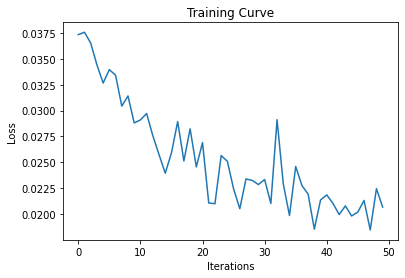

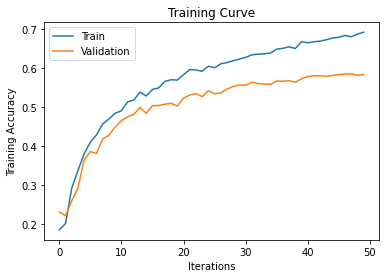

Final Training Accuracy: 0.6913288985148515
Final Validation Accuracy: 0.5837587006960557

 FOLD 1
--------------------------------
Epoch: 0 | Training Acc: 0.15895115442626756 | Validation acc: 0.06497524752475248
Epoch: 1 | Training Acc: 0.24631627799048614 | Validation acc: 0.17141089108910892
Epoch: 2 | Training Acc: 0.2801175697103299 | Validation acc: 0.19786509900990099
Epoch: 3 | Training Acc: 0.33863170514754226 | Validation acc: 0.2532487623762376
Epoch: 4 | Training Acc: 0.36620644312952005 | Validation acc: 0.31698638613861385
Epoch: 5 | Training Acc: 0.4011679622539351 | Validation acc: 0.3510210396039604
Epoch: 6 | Training Acc: 0.4168310322156476 | Validation acc: 0.3694306930693069
Epoch: 7 | Training Acc: 0.4332289128669219 | Validation acc: 0.38567450495049505
Epoch: 8 | Training Acc: 0.4509417179100437 | Validation acc: 0.3989789603960396
Epoch: 9 | Training Acc: 0.4631627799048614 | Validation acc: 0.4104269801980198
Epoch: 10 | Training Acc: 0.46610202266310863 | V

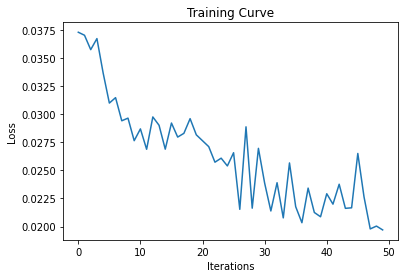

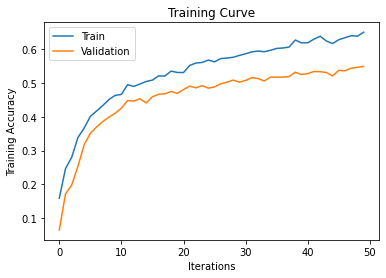

Final Training Accuracy: 0.6501140890281162
Final Validation Accuracy: 0.5488861386138614

 FOLD 2
--------------------------------
Epoch: 0 | Training Acc: 0.15821634373670573 | Validation acc: 0.04826732673267327
Epoch: 1 | Training Acc: 0.2176199868507561 | Validation acc: 0.1421720297029703
Epoch: 2 | Training Acc: 0.27853192559074913 | Validation acc: 0.22045173267326731
Epoch: 3 | Training Acc: 0.31036083072282167 | Validation acc: 0.24458539603960397
Epoch: 4 | Training Acc: 0.3253664384886104 | Validation acc: 0.2625309405940594
Epoch: 5 | Training Acc: 0.3371620837684186 | Validation acc: 0.27011138613861385
Epoch: 6 | Training Acc: 0.3690296631473102 | Validation acc: 0.33261138613861385
Epoch: 7 | Training Acc: 0.3892176199868508 | Validation acc: 0.34761757425742573
Epoch: 8 | Training Acc: 0.3942452720733264 | Validation acc: 0.33926361386138615
Epoch: 9 | Training Acc: 0.40433925049309666 | Validation acc: 0.3587561881188119
Epoch: 10 | Training Acc: 0.4015547047221255 | 

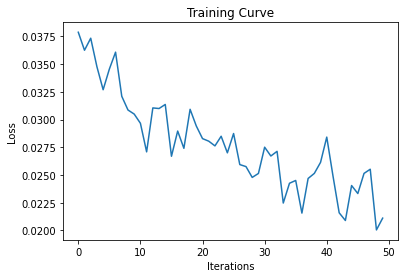

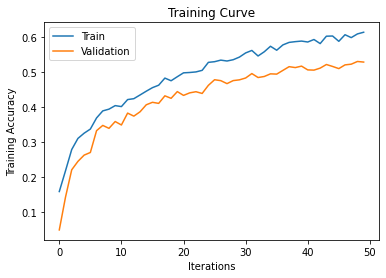

Final Training Accuracy: 0.6145337819545964
Final Validation Accuracy: 0.5290841584158416

 FOLD 3
--------------------------------
Epoch: 0 | Training Acc: 0.1659898673473334 | Validation acc: 0.24907178217821782
Epoch: 1 | Training Acc: 0.21104536489151873 | Validation acc: 0.23468440594059406
Epoch: 2 | Training Acc: 0.2917585180028619 | Validation acc: 0.25386757425742573
Epoch: 3 | Training Acc: 0.34543837258769383 | Validation acc: 0.32936262376237624
Epoch: 4 | Training Acc: 0.3790849673202614 | Validation acc: 0.32317450495049505
Epoch: 5 | Training Acc: 0.3965270526356499 | Validation acc: 0.34761757425742573
Epoch: 6 | Training Acc: 0.4318753142282554 | Validation acc: 0.395884900990099
Epoch: 7 | Training Acc: 0.435974784391074 | Validation acc: 0.40160891089108913
Epoch: 8 | Training Acc: 0.45318482422554823 | Validation acc: 0.41135519801980197
Epoch: 9 | Training Acc: 0.45689755192017634 | Validation acc: 0.4073329207920792
Epoch: 10 | Training Acc: 0.4689252426808988 | V

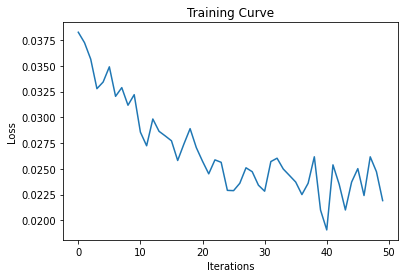

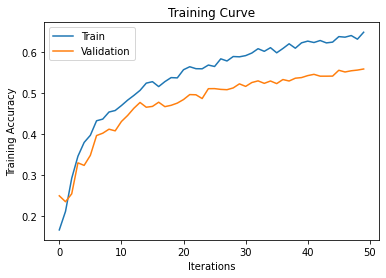

Final Training Accuracy: 0.6475615887380594
Final Validation Accuracy: 0.5580136138613861

 FOLD 4
--------------------------------
Epoch: 0 | Training Acc: 0.18590710445914066 | Validation acc: 0.1530012376237624
Epoch: 1 | Training Acc: 0.19414471903159686 | Validation acc: 0.12128712871287128
Epoch: 2 | Training Acc: 0.28646014618865295 | Validation acc: 0.2301980198019802
Epoch: 3 | Training Acc: 0.3359245078702092 | Validation acc: 0.2747524752475248
Epoch: 4 | Training Acc: 0.3755269366129095 | Validation acc: 0.3346225247524752
Epoch: 5 | Training Acc: 0.39289167343465986 | Validation acc: 0.3604579207920792
Epoch: 6 | Training Acc: 0.4304830413427698 | Validation acc: 0.3968131188118812
Epoch: 7 | Training Acc: 0.4358974358974359 | Validation acc: 0.40439356435643564
Epoch: 8 | Training Acc: 0.44622345979812045 | Validation acc: 0.4192450495049505
Epoch: 9 | Training Acc: 0.4564721352051669 | Validation acc: 0.4243502475247525
Epoch: 10 | Training Acc: 0.4638589163476041 | Vali

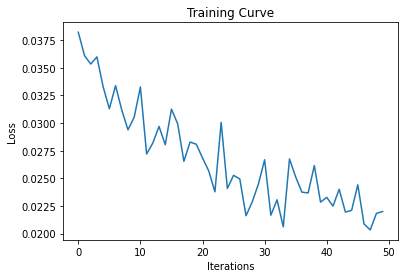

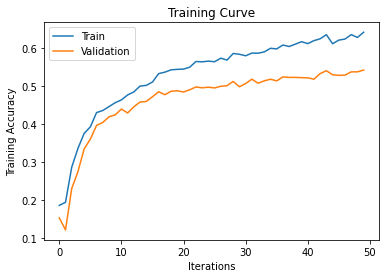

Final Training Accuracy: 0.6421471941833933
Final Validation Accuracy: 0.5425433168316832

 K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 0.5848414539829853 %
Fold 1: 0.5488861386138614 %
Fold 2: 0.5307858910891089 %
Fold 3: 0.5580136138613861 %
Fold 4: 0.5425433168316832 %

 Average: 0.553014082875805 %


In [17]:
if __name__ == "__main__": 
    %%time
    results = {}
    torch.manual_seed(42)
    k_folds = 5
    all_imgs, all_labels = torch.load('train_split.pth')
    kfold = KFold(n_splits=k_folds, shuffle=True)

    # Start print
    print('--------------------------------')

    for fold, (train_ids, test_ids) in enumerate(kfold.split(all_imgs)):

        # Print
        print('\n', f'FOLD {fold}')
        print('--------------------------------')
        
        args = getInputArgs()
        args.nepoch = 50
        train_dl, val_dl = getDataloader(all_imgs, all_labels, train_ids, test_ids, batch_size = 128)
        mdl = EmotionClassificationNet()
        mdl.apply(weight_reset) #Reset weights for proper training
        ce_loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(mdl.parameters(),lr=0.0001)
        #optimizer = torch.optim.Adam(mdl.parameters(),weight_decay=1e-8,lr=0.0001)
        #optimizer = torch.optim.SGD(mdl.parameters(),momentum=0.9,weight_decay=1e-7,lr=0.001)
        device = torch.device('cpu')
        iters, losses, train_acc_list, val_acc_list = [], [], [], []
        #args.val = True #Toggle validation mode
        #args.mdl = '/content/mdl_best.pth'
        if args.gpu:
            device = torch.device('cuda:0')
        if args.mdl is not None:
            mdl.load_state_dict(torch.load(args.mdl))
        mdl = mdl.to(device)
        if args.val:
            print('Val ACC loop')
            mdl.train(False)
            val_acc = calc_acc(mdl, val_dl, 'val', device)
            print('VAL ACC: ', val_acc)
        else:
            #
            # Training loop.
            best_val = -float('inf')
            for epoch in range(args.nepoch):
                #print('Train loop: ', str(epoch))
                mdl.train(True)
                mdl, avg_loss = train_loop(mdl, ce_loss, optimizer, train_dl, device)
                #print('Train ACC loop: ',str(epoch))
                mdl.train(False)
                train_acc = calc_acc(mdl, train_dl, 'train', device)
                #print('Val ACC loop: ',str(epoch))
                val_acc = calc_acc(mdl, val_dl, 'val', device)
                print('Epoch: {} | Training Acc: {} | Validation acc: {}'.format(str(epoch),train_acc,val_acc))

                #Plotting vars
                iters.append(epoch)
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
                losses.append(avg_loss)
                #
                # Early stopping.
                if val_acc > best_val:
                    best_val = val_acc
                    torch.save(mdl.state_dict(), 'mdl_best.pth')
            
            #Plotting
            plt.title("Training Curve")
            plt.plot(iters, losses, label="Train")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.show()

            plt.title("Training Curve")
            plt.plot(iters, train_acc_list, label="Train")
            plt.plot(iters, val_acc_list, label="Validation")
            plt.xlabel("Iterations")
            plt.ylabel("Training Accuracy")
            plt.legend(loc='best')
            plt.show()
            
            print("Final Training Accuracy: {}".format(train_acc_list[-1]))
            print("Final Validation Accuracy: {}".format(val_acc_list[-1]))
            results[fold] = best_val

    # Print fold results
    print('\n',f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
      print(f'Fold {key}: {value} %')
      sum += value
    print('\n',f'Average: {sum/len(results.items())} %')